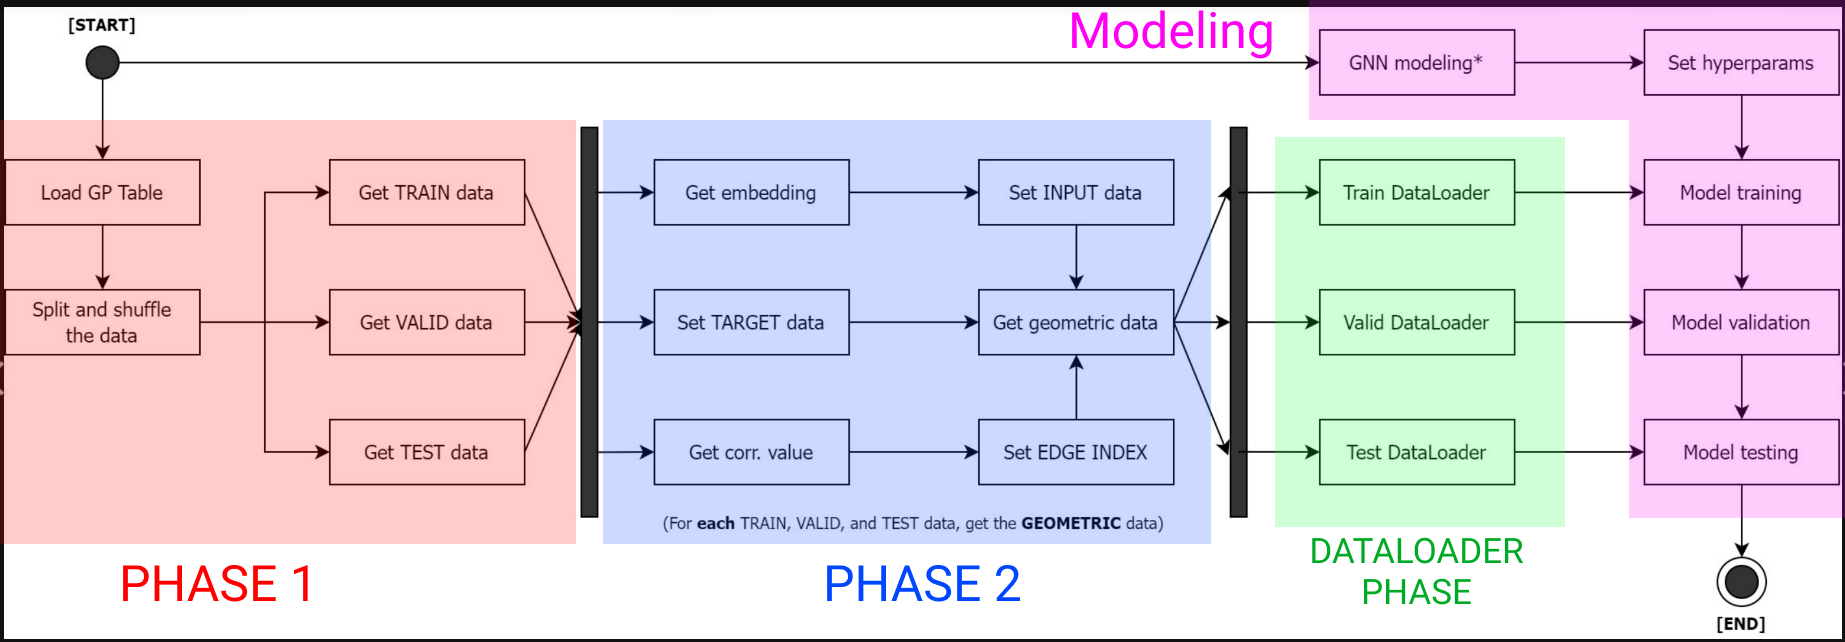

# PHASE 1

## Load dataset

In [ ]:
import pandas as pd
# big_dataset = pd.read_csv('dummy_data.csv')
big_dataset = pd.read_csv('gp_table.csv')

## Split and shuffle data

In [ ]:
y = big_dataset['rice_yield']
x = big_dataset['snps']

# variabel x malah berisikan array snps pada dataset namun dalam bentuk string, perlu dikembalikan menjadi list atau array
from ast import literal_eval
new_x = []
for i in x:
  new_x.append(literal_eval(i))

import numpy as np

# jadikan x dan y bentuk numpy array
x = np.array(new_x)
y = np.array(y)

print(f'len y data: {len(y)}')
print(f'len x data 1st dim: {len(x)}')
print(f'len x data 2nd dim: {len(x[0])}')

len y data: 687
len x data 1st dim: 687
len x data 2nd dim: 1232


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.3, random_state=42)

In [ ]:
print(f'len x_train: {len(x_train)}')
print(f'len x_test: {len(x_test)}')
print(f'len y_train: {len(y_train)}')
print(f'len y_test: {len(y_test)}')
#print(f'len x_val: {len(x_val)}')
#print(f'len y_val: {len(y_val)}')

len x_train: 480
len x_test: 207
len y_train: 480
len y_test: 207


# code

In [ ]:
!pip install deepctr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 30.2 MB/s 
     |████████████████████████████████| 2.9 MB 52.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
import math
import random

import numpy as np
from deepctr.layers.utils import reduce_sum
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Embedding, Input, Lambda
from tensorflow.python.keras.models import Model


def preprocess_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx


def partition_dict(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in vertices.items():
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_list(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in enumerate(vertices):
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_num(num, workers):
    if num % workers == 0:
        return [num // workers] * workers
    else:
        return [num // workers] * workers + [num % workers]

import numpy as np


def create_alias_table(area_ratio):
    """
    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - \
                                 (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias


def alias_sample(accept, alias):
    """
    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random() * N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

def line_loss(y_true, y_pred):
    return -K.mean(K.log(K.sigmoid(y_true * y_pred)))


def create_model(numNodes, embedding_size, order='second'):
    v_i = Input(shape=(1,))
    v_j = Input(shape=(1,))

    first_emb = Embedding(numNodes, embedding_size, name='first_emb')
    second_emb = Embedding(numNodes, embedding_size, name='second_emb')
    context_emb = Embedding(numNodes, embedding_size, name='context_emb')

    v_i_emb = first_emb(v_i)
    v_j_emb = first_emb(v_j)

    v_i_emb_second = second_emb(v_i)
    v_j_context_emb = context_emb(v_j)

    first = Lambda(lambda x: reduce_sum(
        x[0] * x[1], axis=-1, keep_dims=False), name='first_order')([v_i_emb, v_j_emb])
    second = Lambda(lambda x: reduce_sum(
        x[0] * x[1], axis=-1, keep_dims=False), name='second_order')([v_i_emb_second, v_j_context_emb])

    if order == 'first':
        output_list = [first]
    elif order == 'second':
        output_list = [second]
    else:
        output_list = [first, second]

    model = Model(inputs=[v_i, v_j], outputs=output_list)

    return model, {'first': first_emb, 'second': second_emb}


class LINE:
    def __init__(self, graph, embedding_size=8, negative_ratio=5, order='second', ):
        """
        :param graph:
        :param embedding_size:
        :param negative_ratio:
        :param order: 'first','second','all'
        """
        if order not in ['first', 'second', 'all']:
            raise ValueError('mode must be fisrt,second,or all')

        self.graph = graph
        self.idx2node, self.node2idx = preprocess_nxgraph(graph)
        self.use_alias = True

        self.rep_size = embedding_size
        self.order = order

        self._embeddings = {}
        self.negative_ratio = negative_ratio
        self.order = order

        self.node_size = graph.number_of_nodes()
        self.edge_size = graph.number_of_edges()
        self.samples_per_epoch = self.edge_size * (1 + negative_ratio)

        self._gen_sampling_table()
        self.reset_model()

    def reset_training_config(self, batch_size, times):
        self.batch_size = batch_size
        self.steps_per_epoch = (
                                       (self.samples_per_epoch - 1) // self.batch_size + 1) * times

    def reset_model(self, opt='adam'):

        self.model, self.embedding_dict = create_model(
            self.node_size, self.rep_size, self.order)
        self.model.compile(opt, line_loss)
        self.batch_it = self.batch_iter(self.node2idx)

    def _gen_sampling_table(self):

        # create sampling table for vertex
        power = 0.75
        numNodes = self.node_size
        node_degree = np.zeros(numNodes)  # out degree
        node2idx = self.node2idx

        for edge in self.graph.edges():
            node_degree[node2idx[edge[0]]
            ] += self.graph[edge[0]][edge[1]].get('weight', 1.0)

        total_sum = sum([math.pow(node_degree[i], power)
                         for i in range(numNodes)])
        norm_prob = [float(math.pow(node_degree[j], power)) /
                     total_sum for j in range(numNodes)]

        self.node_accept, self.node_alias = create_alias_table(norm_prob)

        # create sampling table for edge
        numEdges = self.graph.number_of_edges()
        total_sum = sum([self.graph[edge[0]][edge[1]].get('weight', 1.0)
                         for edge in self.graph.edges()])
        norm_prob = [self.graph[edge[0]][edge[1]].get('weight', 1.0) *
                     numEdges / total_sum for edge in self.graph.edges()]

        self.edge_accept, self.edge_alias = create_alias_table(norm_prob)

    def batch_iter(self, node2idx):

        edges = [(node2idx[x[0]], node2idx[x[1]]) for x in self.graph.edges()]

        data_size = self.graph.number_of_edges()
        shuffle_indices = np.random.permutation(np.arange(data_size))
        # positive or negative mod
        mod = 0
        mod_size = 1 + self.negative_ratio
        h = []
        t = []
        sign = 0
        count = 0
        start_index = 0
        end_index = min(start_index + self.batch_size, data_size)
        while True:
            if mod == 0:

                h = []
                t = []
                for i in range(start_index, end_index):
                    if random.random() >= self.edge_accept[shuffle_indices[i]]:
                        shuffle_indices[i] = self.edge_alias[shuffle_indices[i]]
                    cur_h = edges[shuffle_indices[i]][0]
                    cur_t = edges[shuffle_indices[i]][1]
                    h.append(cur_h)
                    t.append(cur_t)
                sign = np.ones(len(h))
            else:
                sign = np.ones(len(h)) * -1
                t = []
                for i in range(len(h)):
                    t.append(alias_sample(
                        self.node_accept, self.node_alias))

            if self.order == 'all':
                yield ([np.array(h), np.array(t)], [sign, sign])
            else:
                yield ([np.array(h), np.array(t)], [sign])
            mod += 1
            mod %= mod_size
            if mod == 0:
                start_index = end_index
                end_index = min(start_index + self.batch_size, data_size)

            if start_index >= data_size:
                count += 1
                mod = 0
                h = []
                shuffle_indices = np.random.permutation(np.arange(data_size))
                start_index = 0
                end_index = min(start_index + self.batch_size, data_size)

    def get_embeddings(self, ):
        self._embeddings = {}
        if self.order == 'first':
            embeddings = self.embedding_dict['first'].get_weights()[0]
        elif self.order == 'second':
            embeddings = self.embedding_dict['second'].get_weights()[0]
        else:
            embeddings = np.hstack((self.embedding_dict['first'].get_weights()[
                                        0], self.embedding_dict['second'].get_weights()[0]))
        idx2node = self.idx2node
        for i, embedding in enumerate(embeddings):
            self._embeddings[idx2node[i]] = embedding

        return self._embeddings

    def train(self, batch_size=1024, epochs=1, initial_epoch=0, verbose=1, times=1):
        self.reset_training_config(batch_size, times)
        hist = self.model.fit_generator(self.batch_it, epochs=epochs, initial_epoch=initial_epoch,
                                        steps_per_epoch=self.steps_per_epoch,
                                        verbose=verbose)

        return 

# PHASE 2

Sumber: https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8

In [ ]:
# !pip install torch

In [ ]:
## Install required packages.
## GAUSA DIJALANIN LAGI, BIKIN GARA2
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
!python --version

Python 3.7.13


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 678 kB/s 
     |████████████████████████████████| 3.5 MB 20 kB/s 


In [ ]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader

# print(torch.__version__)

## Define Functions

In [ ]:
# Helper function for visualization.
def visualize_graph(G):
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, cmap="Set2", node_size=1000)
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
# Untuk calculate correlation
# ==================================================
def calc_corr(input_data):
  input_data = pd.DataFrame(input_data)
  # hitung corellation antar SNP
  corr_vals = input_data.corr(method='pearson')
  return corr_vals



# Untuk filter data (ubah data < threshold dan == 1 jadi string 'Invalid')
# ==================================================
def filter_data(input_data):
  input_data = np.array(input_data)

  valid_corr_vals0 = []
  valid_corr_vals1 = []
  threshold_value = 0.07

  for i in range(0, len(input_data)):
    for j in range(0, len(input_data[i])):
      if input_data[i][j] < threshold_value or input_data[i][j] == 1:
        valid_corr_vals1.append('Invalid')
      else:
        valid_corr_vals1.append(input_data[i][j])
    valid_corr_vals0.append(valid_corr_vals1)
    valid_corr_vals1 = []
  
  return valid_corr_vals0



# EDGE INDEX WITHOUT MIRROR
# ===================================================
def crt_edge_index(input_data):
  edge_index_array1 = []
  edge_index_array2 = []
  saved_index = []

  for i in range(0, len(input_data)):
    for j in range(i+1, len(input_data[i])):
      if input_data[i][j] != 'Invalid':
        edge_index_array1.append(i)
        edge_index_array2.append(j)

  # return = array 2d, bukan edge index tensor nya
  edge_index = [edge_index_array1, edge_index_array2]
  return edge_index

## 2.1. Train Data

In [ ]:
section_x = x_train
section_y = y_train

### 2.1.1. Get corr. value & set EDGE INDEX

In [ ]:
transposed_data_x =  section_x.transpose()
corr_vals = calc_corr(transposed_data_x)

# View corellation results
corr_vals

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
0,1.000000,0.229420,0.193799,0.222645,-0.029873,-0.057424,0.280260,0.133875,0.191986,0.132882,...,0.307491,0.148418,-0.013678,0.210050,0.456145,0.129526,-0.090559,0.202324,-0.118736,-0.086080
1,0.229420,1.000000,0.256028,0.329665,-0.084621,-0.056446,0.208232,0.256707,0.221506,0.209895,...,0.187138,0.256216,-0.019339,0.218100,0.253042,0.204268,-0.042665,0.139676,-0.029432,-0.008190
2,0.193799,0.256028,1.000000,0.276772,-0.057030,-0.077875,0.249007,0.283726,0.329669,0.128989,...,0.227762,0.129851,-0.079311,0.261772,0.198925,0.128753,-0.113216,0.132415,0.057816,-0.031603
3,0.222645,0.329665,0.276772,1.000000,-0.116713,-0.113776,0.319957,0.290608,0.251836,0.178830,...,0.350160,0.319335,-0.087206,0.508213,0.364639,0.178711,-0.075873,0.192403,-0.155563,-0.065824
4,-0.029873,-0.084621,-0.057030,-0.116713,1.000000,0.517863,-0.119379,-0.097690,-0.124444,-0.068219,...,-0.152065,-0.107934,0.679383,-0.141664,-0.051169,-0.078102,0.285650,0.438833,0.299075,0.192524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.129526,0.204268,0.128753,0.178711,-0.078102,-0.049347,0.320071,0.452430,0.068433,0.973699,...,0.086674,0.477664,-0.072310,0.325204,0.075522,1.000000,0.094235,0.018841,-0.066573,-0.020764
476,-0.090559,-0.042665,-0.113216,-0.075873,0.285650,0.455821,-0.038855,0.041352,-0.118945,0.099412,...,-0.088118,0.037945,0.317970,-0.027423,-0.092211,0.094235,1.000000,0.170808,0.415447,0.400765
477,0.202324,0.139676,0.132415,0.192403,0.438833,0.284419,0.097437,0.089801,0.146458,0.030060,...,0.079055,0.098064,0.452768,0.150506,0.294623,0.018841,0.170808,1.000000,0.112553,0.082299
478,-0.118736,-0.029432,0.057816,-0.155563,0.299075,0.360758,-0.131710,-0.035651,-0.145993,-0.070439,...,-0.165872,-0.085639,0.261685,-0.161498,-0.125674,-0.066573,0.415447,0.112553,1.000000,0.437444


In [ ]:
# Filter data berdasarkan threshold correlation value
corr_vals_np = np.array(corr_vals)
valid_corr_val = filter_data(corr_vals_np)

In [ ]:
valid_corr_val = np.array(valid_corr_val)

invalid_data = 0
valid_data = 0

for i in valid_corr_val:
  for j in i:
    if j == 'Invalid': invalid_data += 1
    else: valid_data += 1

total_data = invalid_data + valid_data
print(f'total data: {total_data}')
print(f'jumlah valid data: {valid_data}')
print(f'jumlah invalid data: {invalid_data}')
print('')
print(f'valid percentage: { (valid_data / (valid_data + invalid_data)) * 100 } %')

total data: 230400
jumlah valid data: 164140
jumlah invalid data: 66260

valid percentage: 71.24131944444444 %


In [ ]:
# create edge index
edge_index = crt_edge_index(valid_corr_val)
print(edge_index[0])
print(edge_index[1])

edge_index2 = np.transpose(edge_index)
print(edge_index2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
with open('edgeindex.txt', 'w') as f:
    for line in edge_index2:
        f.write(str(line[0]))
        f.write(' ')
        f.write(str(line[1]))
        f.write('\n')

### 2.1.2. Get embedding(?) + set INPUT data

In [ ]:
section_x = np.array(section_x)
section_y = np.array(section_y)

data_x = torch.tensor(section_x, dtype=torch.float)
data_y = torch.tensor(section_y, dtype=torch.float)

### LINE MAIN

In [ ]:
import networkx as nx
G=nx.read_edgelist('edgeindex.txt', create_using = nx.Graph(), nodetype = None)#read graph

model = LINE(G,embedding_size=128,order='second') #init model,order can be ['first','second','all']
model.train(batch_size=1024,epochs=50,verbose=2)# train model
embeddings = model.get_embeddings()# get embedding vectors

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
481/481 - 4s - loss: 0.4788
Epoch 2/50
481/481 - 2s - loss: 0.3536
Epoch 3/50
481/481 - 2s - loss: 0.3438
Epoch 4/50
481/481 - 2s - loss: 0.3350
Epoch 5/50
481/481 - 3s - loss: 0.3280
Epoch 6/50
481/481 - 3s - loss: 0.3253
Epoch 7/50
481/481 - 3s - loss: 0.3254
Epoch 8/50
481/481 - 3s - loss: 0.3213
Epoch 9/50
481/481 - 3s - loss: 0.3196
Epoch 10/50
481/481 - 3s - loss: 0.3187
Epoch 11/50
481/481 - 3s - loss: 0.3169
Epoch 12/50
481/481 - 4s - loss: 0.3170
Epoch 13/50
481/481 - 3s - loss: 0.3180
Epoch 14/50
481/481 - 3s - loss: 0.3148
Epoch 15/50
481/481 - 3s - loss: 0.3142
Epoch 16/50
481/481 - 3s - loss: 0.3136
Epoch 17/50
481/481 - 3s - loss: 0.3125
Epoch 18/50
481/481 - 3s - loss: 0.3124
Epoch 19/50
481/481 - 3s - loss: 0.3146
Epoch 20/50
481/481 - 2s - loss: 0.3119
Epoch 21/50
481/481 - 2s - loss: 0.3115
Epoch 22/50
481/481 - 2s - loss: 0.3113
Epoch 23/50
481/481 - 2s - loss: 0.3104
Epoch 24/50
481/481 - 2s - loss: 0.3103
Epoch 25/50
481/481 - 2s - loss: 0.3122
Epoch 26/

In [ ]:
result = embeddings.items()
data = list(result)
numpyArray = np.array(data)

print(numpyArray[len(numpyArray)-1])

['479'
 array([ 0.00793302, -0.03883128,  0.03456639, -0.01938438, -0.01422334,
         0.00443106, -0.01563758, -0.00796019,  0.04702545, -0.03481952,
        -0.00953032, -0.01533026, -0.03510682, -0.00229052, -0.03189384,
         0.00469832, -0.0315927 ,  0.03145381,  0.02378966, -0.0057109 ,
        -0.04908089,  0.01376395, -0.04854362,  0.01226208,  0.04639522,
        -0.04257944, -0.01467394,  0.0243792 , -0.02918862,  0.00653218,
        -0.02720403, -0.04511115, -0.04804275,  0.03268478, -0.01570085,
        -0.04485912,  0.04967229, -0.04791277, -0.03117598,  0.04460336,
         0.04052433,  0.00232003,  0.00123558,  0.00096833, -0.03559502,
        -0.03911676, -0.01892579, -0.04041694,  0.01672325, -0.0112711 ,
         0.01314595,  0.04142236,  0.01205803,  0.04035569, -0.02243878,
        -0.04867134,  0.00318385,  0.02604355, -0.03478415,  0.02354142,
        -0.00283229, -0.02519113,  0.0050274 , -0.03241896,  0.04949716,
        -0.03296046,  0.01531054, -0.0161456

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
embedding_values = embeddings.values()
embedding_values2 = list(embedding_values)

embedding_keys = list(embeddings) 

In [ ]:
np_embedding_keys = np.array(embedding_keys)
np_embedding_values2 = np.array(embedding_values2)

In [ ]:
# sort_np = np_embedding_keys.sort()

new_np_embedding_keys = []

for i in range(0, len(np_embedding_keys)):
  new_np_embedding_keys.append(int(np_embedding_keys[i]))

print(new_np_embedding_keys)

[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 128, 131, 132, 133, 134, 135, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 171, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 196, 197, 198, 199, 200, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 242, 243, 246, 247, 249, 252, 253, 254, 256, 257, 259, 2

In [ ]:
sort_new_np_embedding_keys = new_np_embedding_keys
sort_new_np_embedding_keys.sort()
print(sort_new_np_embedding_keys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
not_in = []
for i in range(0, 480):
  if i not in sort_new_np_embedding_keys:
    not_in.append(i)

In [ ]:
print(len(not_in))

0


In [ ]:
new_section_y = []
for i in range(0, 480):
  if i in not_in:
    continue
  new_section_y.append(section_y[i])

In [ ]:
print(len(new_section_y))

480


In [ ]:
print(type(np_embedding_keys))
print(len(np_embedding_values2))

<class 'numpy.ndarray'>
480


In [ ]:
X_train = np_embedding_values2
y_train = new_section_y

## 2.2. Test Data

In [ ]:
section_x = x_test
section_y = y_test

### 2.1.1. Get corr. value & set EDGE INDEX

In [ ]:
transposed_data_x =  section_x.transpose()
corr_vals = calc_corr(transposed_data_x)

# View corellation results
corr_vals

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.000000,0.238003,-0.037486,0.188566,0.120601,0.284214,0.178156,0.197688,0.290921,-0.089812,...,0.120601,0.048539,0.257850,0.253133,-0.062879,0.278302,0.087583,0.101411,-0.076195,0.256811
1,0.238003,1.000000,-0.011126,0.146220,0.226556,0.295718,0.101366,0.293575,0.143369,-0.090796,...,0.226556,0.221691,0.269197,0.272898,-0.135245,0.295645,0.294520,0.095138,-0.091558,0.210901
2,-0.037486,-0.011126,1.000000,0.049189,-0.078942,-0.066627,0.319172,-0.092627,0.032494,0.132903,...,-0.078942,-0.131258,-0.066363,-0.004051,0.127480,0.023512,-0.079488,-0.068844,0.186291,0.145239
3,0.188566,0.146220,0.049189,1.000000,0.130171,0.071420,0.123247,0.077840,0.123136,-0.048085,...,0.130171,0.183448,0.440388,0.394079,-0.049499,0.314374,0.214509,0.239527,-0.046720,0.586997
4,0.120601,0.226556,-0.078942,0.130171,1.000000,0.257379,0.086139,0.330342,0.136752,-0.047976,...,1.000000,0.366933,0.296827,0.355904,-0.099018,0.196194,0.401678,0.319387,-0.052604,0.069872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.278302,0.295645,0.023512,0.314374,0.196194,0.207620,0.128111,0.145132,0.164460,-0.085389,...,0.196194,0.195639,0.381280,0.321446,-0.101124,1.000000,0.241221,0.304770,-0.099505,0.444491
203,0.087583,0.294520,-0.079488,0.214509,0.401678,0.202337,0.033351,0.258074,0.172168,-0.065531,...,0.401678,0.407199,0.490671,0.265068,-0.113144,0.241221,1.000000,0.366715,-0.085039,0.116499
204,0.101411,0.095138,-0.068844,0.239527,0.319387,0.171868,0.034846,0.246955,0.205008,-0.016016,...,0.319387,0.272583,0.349881,0.297978,-0.109983,0.304770,0.366715,1.000000,-0.068474,0.146977
205,-0.076195,-0.091558,0.186291,-0.046720,-0.052604,-0.084118,0.154970,-0.089545,-0.066273,0.618198,...,-0.052604,-0.042444,-0.100286,-0.068691,0.585884,-0.099505,-0.085039,-0.068474,1.000000,-0.089036


In [ ]:
# Filter data berdasarkan threshold correlation value
corr_vals_np = np.array(corr_vals)
valid_corr_val = filter_data(corr_vals_np)

In [ ]:
valid_corr_val = np.array(valid_corr_val)

invalid_data = 0
valid_data = 0

for i in valid_corr_val:
  for j in i:
    if j == 'Invalid': invalid_data += 1
    else: valid_data += 1

total_data = invalid_data + valid_data
print(f'total data: {total_data}')
print(f'jumlah valid data: {valid_data}')
print(f'jumlah invalid data: {invalid_data}')
print('')
print(f'valid percentage: { (valid_data / (valid_data + invalid_data)) * 100 } %')

total data: 42849
jumlah valid data: 28366
jumlah invalid data: 14483

valid percentage: 66.19991131648347 %


In [ ]:
# create edge index
edge_index = crt_edge_index(valid_corr_val)
print(edge_index[0])
print(edge_index[1])

edge_index2 = np.transpose(edge_index)
print(edge_index2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 

In [ ]:
with open('edgeindex.txt', 'w') as f:
    for line in edge_index2:
        f.write(str(line[0]))
        f.write(' ')
        f.write(str(line[1]))
        f.write('\n')

### 2.1.2. Get embedding(?) + set INPUT data

In [ ]:
section_x = np.array(section_x)
section_y = np.array(section_y)

data_x = torch.tensor(section_x, dtype=torch.float)
data_y = torch.tensor(section_y, dtype=torch.float)

### LINE MAIN

In [ ]:
import networkx as nx
G=nx.read_edgelist('edgeindex.txt', create_using = nx.Graph(), nodetype = None)#read graph

model = LINE(G,embedding_size=128,order='second') #init model,order can be ['first','second','all']
model.train(batch_size=1024, epochs=50,verbose=2)# train model
embeddings = model.get_embeddings()# get embedding vectors

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
84/84 - 1s - loss: 0.6825
Epoch 2/50
84/84 - 0s - loss: 0.5091
Epoch 3/50
84/84 - 0s - loss: 0.3735
Epoch 4/50
84/84 - 0s - loss: 0.3576
Epoch 5/50
84/84 - 0s - loss: 0.3531
Epoch 6/50
84/84 - 0s - loss: 0.3510
Epoch 7/50
84/84 - 0s - loss: 0.3481
Epoch 8/50
84/84 - 0s - loss: 0.3464
Epoch 9/50
84/84 - 0s - loss: 0.3430
Epoch 10/50
84/84 - 0s - loss: 0.3403
Epoch 11/50
84/84 - 0s - loss: 0.3379
Epoch 12/50
84/84 - 0s - loss: 0.3365
Epoch 13/50
84/84 - 0s - loss: 0.3326
Epoch 14/50
84/84 - 0s - loss: 0.3299
Epoch 15/50
84/84 - 0s - loss: 0.3294
Epoch 16/50
84/84 - 0s - loss: 0.3289
Epoch 17/50
84/84 - 0s - loss: 0.3260
Epoch 18/50
84/84 - 0s - loss: 0.3240
Epoch 19/50
84/84 - 0s - loss: 0.3239
Epoch 20/50
84/84 - 0s - loss: 0.3218
Epoch 21/50
84/84 - 0s - loss: 0.3219
Epoch 22/50
84/84 - 0s - loss: 0.3191
Epoch 23/50
84/84 - 0s - loss: 0.3181
Epoch 24/50
84/84 - 0s - loss: 0.3179
Epoch 25/50
84/84 - 0s - loss: 0.3177
Epoch 26/50
84/84 - 0s - loss: 0.3164
Epoch 27/50
84/84 - 0

In [ ]:
result = embeddings.items()
data = list(result)
numpyArray = np.array(data)

print(numpyArray[len(numpyArray)-1])

['32'
 array([-0.01858536, -0.02288464,  0.00773285, -0.00763128,  0.00962305,
         0.00510243, -0.03892695, -0.03844566,  0.04209394, -0.04292857,
        -0.04566134,  0.04588232, -0.02610226,  0.03451163,  0.02904822,
        -0.0434515 , -0.04239352, -0.00040417, -0.03563803, -0.00310587,
        -0.0216741 , -0.02411047, -0.02473986,  0.02780709,  0.02877537,
         0.04014823, -0.00851678,  0.03631181,  0.00805259, -0.0161587 ,
        -0.00833138,  0.00201654, -0.04796158,  0.03105147,  0.04341977,
        -0.02195932, -0.03377276,  0.00199921,  0.01888528,  0.03486415,
         0.03494081, -0.02768438,  0.03515557, -0.0341203 ,  0.0263991 ,
         0.01308339,  0.02835914,  0.03615135, -0.0328004 ,  0.04625073,
        -0.01539423, -0.0269231 , -0.00768858, -0.00879868, -0.02180988,
         0.01168369, -0.02274591,  0.01430753, -0.00244993, -0.04610556,
         0.00484747,  0.03731836, -0.03219854, -0.02742083,  0.03494952,
         0.00430067,  0.00591073, -0.00500183

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
embedding_values = embeddings.values()
embedding_values2 = list(embedding_values)

embedding_keys = list(embeddings) 

In [ ]:
np_embedding_keys = np.array(embedding_keys)
np_embedding_values2 = np.array(embedding_values2)

In [ ]:
# sort_np = np_embedding_keys.sort()

new_np_embedding_keys = []

for i in range(0, len(np_embedding_keys)):
  new_np_embedding_keys.append(int(np_embedding_keys[i]))

print(new_np_embedding_keys)

[0, 1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 34, 35, 37, 38, 39, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 141, 142, 143, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 167, 168, 171, 174, 175, 176, 177, 178, 179, 181, 182, 183, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 199, 200, 202, 203, 204, 206, 11, 18, 41, 43, 56, 85, 140, 169, 172, 198, 2, 9, 15, 29, 33, 36, 45, 47, 57, 58, 64, 68, 71, 80, 91, 97, 100, 110, 115, 137, 139, 144, 150, 161, 166, 170, 173, 180, 184, 185, 190, 195, 201, 205, 32]


In [ ]:
sort_new_np_embedding_keys = new_np_embedding_keys
sort_new_np_embedding_keys.sort()
print(sort_new_np_embedding_keys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206]


In [ ]:
not_in = []
for i in range(0, 480):
  if i not in sort_new_np_embedding_keys:
    not_in.append(i)

In [ ]:
print(len(not_in))

273


In [ ]:
new_section_y = []
for i in range(0, 480):
  if i in not_in:
    continue
  new_section_y.append(section_y[i])

In [ ]:
print(len(new_section_y))

207


In [ ]:
print(type(np_embedding_keys))
print(len(np_embedding_values2))

<class 'numpy.ndarray'>
207


In [ ]:
X_test = np_embedding_values2
y_test = new_section_y

In [ ]:
import networkx as nx
G=nx.read_edgelist('edgeindex.txt', create_using = nx.Graph(), nodetype = None)#read graph

model = LINE(G,embedding_size=10,order='second') #init model,order can be ['first','second','all']
model.train(batch_size=1024, epochs=500,verbose=2)# train model
embeddings = model.get_embeddings()# get embedding vectors

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
84/84 - 1s - loss: 0.6924
Epoch 2/500
84/84 - 0s - loss: 0.6690
Epoch 3/500
84/84 - 0s - loss: 0.5872
Epoch 4/500
84/84 - 0s - loss: 0.4947
Epoch 5/500
84/84 - 0s - loss: 0.4316
Epoch 6/500
84/84 - 0s - loss: 0.3961
Epoch 7/500
84/84 - 0s - loss: 0.3788
Epoch 8/500
84/84 - 0s - loss: 0.3684
Epoch 9/500
84/84 - 0s - loss: 0.3634
Epoch 10/500
84/84 - 0s - loss: 0.3590
Epoch 11/500
84/84 - 0s - loss: 0.3576
Epoch 12/500
84/84 - 0s - loss: 0.3562
Epoch 13/500
84/84 - 0s - loss: 0.3545
Epoch 14/500
84/84 - 0s - loss: 0.3531
Epoch 15/500
84/84 - 0s - loss: 0.3524
Epoch 16/500
84/84 - 0s - loss: 0.3511
Epoch 17/500
84/84 - 0s - loss: 0.3517
Epoch 18/500
84/84 - 0s - loss: 0.3500
Epoch 19/500
84/84 - 0s - loss: 0.3493
Epoch 20/500
84/84 - 0s - loss: 0.3485
Epoch 21/500
84/84 - 0s - loss: 0.3490
Epoch 22/500
84/84 - 0s - loss: 0.3483
Epoch 23/500
84/84 - 0s - loss: 0.3510
Epoch 24/500
84/84 - 0s - loss: 0.3494
Epoch 25/500
84/84 - 0s - loss: 0.3488
Epoch 26/500
84/84 - 0s - loss: 0.

In [ ]:
import networkx as nx
G=nx.read_edgelist('edgeindex.txt', create_using = nx.Graph(), nodetype = None)#read graph

model = LINE(G,embedding_size=50,order='second') #init model,order can be ['first','second','all']
model.train(batch_size=1024, epochs=500,verbose=2)# train model
embeddings = model.get_embeddings()# get embedding vectors

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
84/84 - 1s - loss: 0.6892
Epoch 2/500
84/84 - 0s - loss: 0.5918
Epoch 3/500
84/84 - 0s - loss: 0.4252
Epoch 4/500
84/84 - 0s - loss: 0.3714
Epoch 5/500
84/84 - 0s - loss: 0.3599
Epoch 6/500
84/84 - 0s - loss: 0.3557
Epoch 7/500
84/84 - 0s - loss: 0.3531
Epoch 8/500
84/84 - 0s - loss: 0.3511
Epoch 9/500
84/84 - 0s - loss: 0.3513
Epoch 10/500
84/84 - 0s - loss: 0.3505
Epoch 11/500
84/84 - 0s - loss: 0.3502
Epoch 12/500
84/84 - 0s - loss: 0.3474
Epoch 13/500
84/84 - 0s - loss: 0.3479
Epoch 14/500
84/84 - 0s - loss: 0.3459
Epoch 15/500
84/84 - 0s - loss: 0.3456
Epoch 16/500
84/84 - 0s - loss: 0.3441
Epoch 17/500
84/84 - 0s - loss: 0.3438
Epoch 18/500
84/84 - 0s - loss: 0.3424
Epoch 19/500
84/84 - 0s - loss: 0.3411
Epoch 20/500
84/84 - 0s - loss: 0.3415
Epoch 21/500
84/84 - 0s - loss: 0.3386
Epoch 22/500
84/84 - 0s - loss: 0.3372
Epoch 23/500
84/84 - 0s - loss: 0.3356
Epoch 24/500
84/84 - 0s - loss: 0.3341
Epoch 25/500
84/84 - 0s - loss: 0.3332
Epoch 26/500
84/84 - 0s - loss: 0.

# MLP

https://www.projectpro.io/recipes/use-mlp-classifier-and-regressor-in-python

In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler
#X_scaler = StandardScaler()
#X_train = X_scaler.fit_transform(X_train)
#X_test = X_scaler.transform(X_test)

# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(y_train)
# y_test = y_scaler.transform(y_test)

In [ ]:
model = MLPRegressor(learning_rate_init=0.001, solver="adam")
model.fit(X_train, y_train)
print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)


print(metrics.r2_score(expected_y, predicted_y))
# print(metrics.mean_squared_log_error(expected_y, predicted_y))

MSE = np.square(np.subtract(expected_y, predicted_y)).mean()
print(MSE)

MLPRegressor()
-3.1310195764563096
15.886072693762628


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
model = MLPRegressor(learning_rate_init=0.0001, solver="adam")
model.fit(X_train, y_train)
print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)


print(metrics.r2_score(expected_y, predicted_y))
# print(metrics.mean_squared_log_error(expected_y, predicted_y))

MSE = np.square(np.subtract(expected_y, predicted_y)).mean()
print(MSE)

MLPRegressor(learning_rate_init=0.0001)
-3.307745860104708
16.565683752721906


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


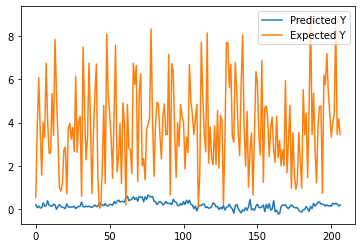

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# plot lines
plt.plot(predicted_y, label = "Predicted Y")
plt.plot(expected_y, label = "Expected Y")
# plt.plot(x, np.sin(x), label = "curve 1")
# plt.plot(x, np.cos(x), label = "curve 2")
plt.legend()
plt.show()

In [ ]:
model = MLPRegressor(learning_rate_init=0.001, solver="adam")
model.fit(X_train, y_train)
print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)


print(metrics.r2_score(expected_y, predicted_y))
# print(metrics.mean_squared_log_error(expected_y, predicted_y))

MSE = np.square(np.subtract(expected_y, predicted_y)).mean()
print(MSE)

MLPRegressor()
-2.041957696413346
11.698022776746871


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
model = MLPRegressor(learning_rate_init=0.0001, solver="adam")
model.fit(X_train, y_train)
print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)


print(metrics.r2_score(expected_y, predicted_y))
# print(metrics.mean_squared_log_error(expected_y, predicted_y))

MSE = np.square(np.subtract(expected_y, predicted_y)).mean()
print(MSE)

MLPRegressor(learning_rate_init=0.0001)
-3.597338726457708
17.679329728330003


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


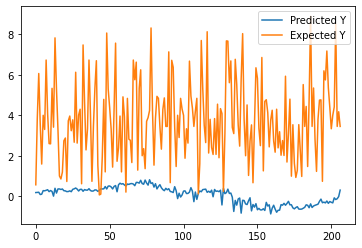

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# plot lines
plt.plot(predicted_y, label = "Predicted Y")
plt.plot(expected_y, label = "Expected Y")
# plt.plot(x, np.sin(x), label = "curve 1")
# plt.plot(x, np.cos(x), label = "curve 2")
plt.legend()
plt.show()